# Cycles I: Gas Turbine

In this sesion we will use TESPy for cycle performance analysis of a gas turbine.

This example teaches us

- the basic technical setup of an open cycle gas turbine, consisting of
    - compressor,
    - combustion chamber and
    - turbine
- to find approaches for stable cycle calculations like
    - stepwise calculations or
    - starting values from similar calculations
- how to store information in the context of cycle performance analyses in
    - data files
    - saved figures

## Gas Turbine Cycle

### Hydrogen Fired Open Cycle Gas Turbine
The gas turbine is a traditional concept in power plant engineering. Usually fueled by natural gas or (less often) by liquid hydrocarbons it belongs to the class of power plants with relatively high fuel costs and relatively low investment costs. Combined with a bottoming steam cycle, gas turbines can reach the highest efficiency of conventioal thermal power plants. 

However, in the course of energy transition also gas turbine power plants need to be phased out. Nevertheless, the gas turbine remains an interesting concept, as it could serve as a backup power plant in sustainable energy systems, if fueled with hydrogen generated from renewable energies.

### Combustion Chamber
The conbustion with fuel and air is a new feature in comparison to the setups considered in this course so far. For that reason we start setting up the combustion chamber in a very reduced TESPy network as a first step.

TESPy takes care of the complete combustion calculation including the calculation of the heating value of the fuel and the exhaust gas composition. Hence, gas compositions only need to be defined for the combustion air and the fuel gas. The following script sets up a TESPy network containing 

- two sources (for air and fuel respectively),
- a diabatic combustion chamber (as this is the most general type) and
- a sink for the hot exhaus gases.

A straight forward approach is to simulate the combustion with both air and fuel completely defined concerning their thermodynamic properties, composition and mass flows. Start with mass flows of 100 kg/s of air and 1 kg/s of hydrogen:

In [22]:
from tespy.networks import Network
from tespy.connections import Connection
from tespy.components import (
    Source,
    DiabaticCombustionChamber,
    Sink
)

# create tespy network
gt = Network()

# create components without any parametrization
amb = Source('ambient')
tank = Source('tank')
cc = DiabaticCombustionChamber('combustion chamber')
stack = Sink('stack')

# create connnections and add them to network to set up topology
in_a = Connection(amb, 'out1', cc, 'in1', 'inlet air')
in_f = Connection(tank, 'out1', cc, 'in2', 'inlet fuel')
exh = Connection(cc, 'out1', stack, 'in1', 'exhaust')

gt.add_conns(in_a, in_f, exh)

# parametrization
air = {'N2': 0.79, 'O2': 0.21} #simplified air composition
fuel = {'H2': 1} #pure hydorgen
p_amb = 1e5 #ambient pressure in Pa
T_amb = 293.15 #ambient temperaturein in K
m_air = 100 #air mass flow in kg/s
m_fuel = 1 #fuel mass flow in kg/s

in_a.set_attr(p=p_amb, T=T_amb, m=m_air, fluid=air)
in_f.set_attr(p=p_amb, T=T_amb, m=m_fuel, fluid=fuel)

cc.set_attr(pr=0.95, eta=1)

# calculate network and print results
gt.set_attr(iterinfo=False) #just here to save some space
gt.solve(mode='design')
gt.print_results()
T_out = exh.get_attr('T').val
print(f'The exhaust temperature is {(T_out-273.15):.0f} °C')


##### RESULTS (DiabaticCombustionChamber) #####
+--------------------+----------+----------+----------+----------+-----------+
|                    |     lamb |       ti |       pr |      eta |    Q_loss |
|--------------------+----------+----------+----------+----------+-----------|
| combustion chamber | 2.65e+00 | 1.20e+08 | 9.50e-01 | 1.00e+00 | -1.33e-08 |
+--------------------+----------+----------+----------+----------+-----------+
##### RESULTS (Connection) #####
+------------+-----------+-----------+-----------+-----------+------------+----------------------+
|            |         m |         p |         h |         T |          x | phase                |
|------------+-----------+-----------+-----------+-----------+------------+----------------------|
| inlet air  | 1.000e+02 | 1.000e+05 | 2.962e+05 | 2.931e+02 |  0.000e+00 | nan                  |
| inlet fuel | 1.000e+00 | 1.000e+05 | 3.860e+06 | 2.931e+02 | -1.000e+00 | state not recognised |
| exhaust    | 1.010e+02 | 9

Now you could play around with that script. Lower the fuel mass flow first, then raise it. You will most probably run into problems allready here if the ratio of fuel to air exceeds stoichiometric combustion. Fortunately this can be circumvented by using the combustion chambers 'lamb' attribute. You could revise the script and test ist with various fuel to air ratios and by this determine the soichiometric exhaust temperature. Start with a $\lambda$ of 3:

In [ ]:
from tespy.networks import Network
from tespy.connections import Connection
from tespy.components import (
    Source,
    DiabaticCombustionChamber,
    Sink
)

# create tespy network
gt = Network()

# create components without any parametrization
amb = Source('ambient')
tank = Source('tank')
cc = DiabaticCombustionChamber('combustion chamber')
stack = Sink('stack')

# create connnections and add them to network to set up topology
in_a = Connection(amb, 'out1', cc, 'in1', 'inlet air')
in_f = Connection(tank, 'out1', cc, 'in2', 'inlet fuel')
exh = Connection(cc, 'out1', stack, 'in1', 'exhaust')

gt.add_conns(in_a, in_f, exh)

# parametrization
air = {'N2': 0.79, 'O2': 0.21} #simplified air composition
fuel = {'H2': 1} #pure hydorgen
p_amb = 1e5 #ambient pressure in Pa
T_amb = 293.15 #ambient temperaturein in K
m_air = 100 #air mass flow in kg/s

in_a.set_attr(p=p_amb, T=T_amb, m=m_air, fluid=air)
in_f.set_attr(p=p_amb, T=T_amb, fluid=fuel)

cc.set_attr(pr=0.95, eta=1, lamb=3)

# calculate network and print results
gt.set_attr(iterinfo=False) #just here to save some space
gt.solve(mode='design')
gt.print_results()
T_out = exh.get_attr('T').val
print(f'The exhaust temperature is {(T_out-273.15):.0f} °C')


##### RESULTS (DiabaticCombustionChamber) #####
+--------------------+----------+----------+----------+----------+-----------+
|                    |     lamb |       ti |       pr |      eta |    Q_loss |
|--------------------+----------+----------+----------+----------+-----------|
| combustion chamber | 3.00e+00 | 1.06e+08 | 9.50e-01 | 1.00e+00 | -1.17e-08 |
+--------------------+----------+----------+----------+----------+-----------+
##### RESULTS (Connection) #####
+------------+-----------+-----------+-----------+-----------+------------+----------------------+
|            |         m |         p |         h |         T |          x | phase                |
|------------+-----------+-----------+-----------+-----------+------------+----------------------|
| inlet air  | 1.000e+02 | 1.000e+05 | 2.962e+05 | 2.931e+02 |  0.000e+00 | nan                  |
| inlet fuel | 8.820e-01 | 1.000e+05 | 3.860e+06 | 2.931e+02 | -1.000e+00 | state not recognised |
| exhaust    | 1.009e+02 | 9

It is also possible to fire to a defined exhaust temperature, as with TESPy it is easily possible to change results and inputs. You could for example revise your script in order to find the $\lambda$ of a combustion chamber with the outlet temperature of 1000 °C first and then again try to explore the limits of stability:

In [ ]:
from tespy.networks import Network
from tespy.connections import Connection
from tespy.components import (
    Source,
    DiabaticCombustionChamber,
    Sink
)

# create tespy network
gt = Network()

# create components without any parametrization
amb = Source('ambient')
tank = Source('tank')
cc = DiabaticCombustionChamber('combustion chamber')
stack = Sink('stack')

# create connnections and add them to network to set up topology
in_a = Connection(amb, 'out1', cc, 'in1', 'inlet air')
in_f = Connection(tank, 'out1', cc, 'in2', 'inlet fuel')
exh = Connection(cc, 'out1', stack, 'in1', 'exhaust')

gt.add_conns(in_a, in_f, exh)

# parametrization
air = {'N2': 0.79, 'O2': 0.21} #simplified air composition
fuel = {'H2': 1} #pure hydorgen
p_amb = 1e5 #ambient pressure in Pa
T_amb = 293.15 #ambient temperaturein in K
m_air = 100 #air mass flow in kg/s
T_out = 1273.15 #desired outlet temperature in K

in_a.set_attr(p=p_amb, T=T_amb, m=m_air, fluid=air)
in_f.set_attr(p=p_amb, T=T_amb, fluid=fuel)
exh.set_attr(T=T_out)

cc.set_attr(pr=0.95, eta=1,)

# calculate network and print results
gt.set_attr(iterinfo=False) #just here to save some space
gt.solve(mode='design')
gt.print_results()
lamb = cc.get_attr('lamb').val
print(f'Lambda for achieving the exhaust temperature of {(T_out-273.15):.0f} °C is {lamb:.2f}')


##### RESULTS (DiabaticCombustionChamber) #####
+--------------------+----------+----------+----------+----------+-----------+
|                    |     lamb |       ti |       pr |      eta |    Q_loss |
|--------------------+----------+----------+----------+----------+-----------|
| combustion chamber | 2.67e+00 | 1.19e+08 | 9.50e-01 | 1.00e+00 | -2.64e-05 |
+--------------------+----------+----------+----------+----------+-----------+
##### RESULTS (Connection) #####
+------------+-----------+-----------+-----------+-----------+------------+----------------------+
|            |         m |         p |         h |         T |          x | phase                |
|------------+-----------+-----------+-----------+-----------+------------+----------------------|
| inlet air  | 1.000e+02 | 1.000e+05 | 2.962e+05 | 2.931e+02 |  0.000e+00 | nan                  |
| inlet fuel | 9.895e-01 | 1.000e+05 | 3.860e+06 | 2.931e+02 | -1.000e+00 | state not recognised |
| exhaust    | 1.010e+02 | 9

Non converging calculations can have different reasons. One reason could be to specifiy a physically impossible configuration, e.g. an outlet temperature, that is above the adiabatic outlet temperature at stoichiometric combustion. However, another reason could be that the combustion chamber model has limits of application. Here, the model is not applicable for under-stoichiometric combustion, although it is pysically possible.  

### Gas Turbine Cycle Setup

Knowing calculation modes and stability issues of combustion chambers the next step is to set up a complete gas turbine cycle in TESPy. The topology is shown in the figure below.

![gas turbine heat balance diagram](img/HBD_GT.png)

It is recommended to build the model stepwise and to chose a stable configuration. The respective script from the section above can be used as a starting point. A resonable approach would be to first add the compressor and then the turbine. For reasons of compactness the script below takes these two steps at once.

In [5]:
from tespy.networks import Network
from tespy.connections import Connection
from tespy.components import (
    Source,
    Compressor,
    DiabaticCombustionChamber,
    Turbine,
    Sink
)

# create tespy network
gt = Network()

# create components without any parametrization
amb = Source('ambient')
tank = Source('tank')
comp = Compressor('compressor')
cc = DiabaticCombustionChamber('combustion chamber')
turb = Turbine('turbine')
stack = Sink('stack')

# create connnections and add them to network to set up topology
c_1 = Connection(amb, 'out1', comp, 'in1', 'inlet air')
c_2 = Connection(comp, 'out1', cc, 'in1', 'compressor outlet')
c_3 = Connection(cc, 'out1', turb, 'in1', 'turbine inlet')
c_4 = Connection(turb, 'out1', stack, 'in1', 'exhaust')
c_5 = Connection(tank, 'out1', cc, 'in2', 'inlet fuel')

gt.add_conns(c_1, c_2, c_3, c_4, c_5)

# parametrization
air = {'N2': 0.79, 'O2': 0.21} #simplified air composition
fuel = {'H2': 1} #pure hydorgen
p_amb = 1e5 #ambient pressure in Pa
T_amb = 293.15 #ambient temperaturein in K
m_air = 100 #air mass flow in kg/s
Pi = 10 #compressor pressure ratio
lamb = 3 #combustion chamber lambda

c_1.set_attr(p=p_amb, T=T_amb, m=m_air, fluid=air)
c_4.set_attr(p=p_amb)
c_5.set_attr(p=p_amb*Pi, T=T_amb, fluid=fuel)

comp.set_attr(pr=Pi, eta_s=0.9)
cc.set_attr(pr=0.95, eta=1, lamb=lamb)
turb.set_attr(eta_s=0.9)

# calculate network and print results
gt.set_attr(iterinfo=False) #just here to save some space
gt.solve(mode='design')
gt.print_results()
TIT = c_3.get_attr('T').val
eta_th = (abs(turb.get_attr('P').val)-comp.get_attr('P').val) / cc.get_attr('ti').val
print(f'The turbine inlet temperature is {(TIT-273.15):.0f} °C')
print(f'The cycle efficiency is {(eta_th*100):.2f} %')


##### RESULTS (DiabaticCombustionChamber) #####
+--------------------+----------+----------+----------+----------+----------+
|                    |     lamb |       ti |       pr |      eta |   Q_loss |
|--------------------+----------+----------+----------+----------+----------|
| combustion chamber | 3.00e+00 | 1.06e+08 | 9.50e-01 | 1.00e+00 | 2.35e-08 |
+--------------------+----------+----------+----------+----------+----------+
##### RESULTS (Compressor) #####
+------------+----------+----------+----------+--------+
|            |        P |    eta_s |       pr |   igva |
|------------+----------+----------+----------+--------|
| compressor | 3.06e+07 | 9.00e-01 | 1.00e+01 |    nan |
+------------+----------+----------+----------+--------+
##### RESULTS (Turbine) #####
+---------+-----------+----------+----------+
|         |         P |    eta_s |       pr |
|---------+-----------+----------+----------|
| turbine | -6.83e+07 | 9.00e-01 | 1.05e-01 |
+---------+-----------+------

The script above specifies $\lambda$ in order to allow for stable calculations within an obviuos range of application. In the next step the model could be modified to another common setup. Technical limits in terms of cooling needed or materials applied is closely related to the amximum temperatures. For thar reason it is as well sensible to specify the turbine inlet temperature instead of lambda.


In [3]:
from tespy.networks import Network
from tespy.connections import Connection
from tespy.components import (
    Source,
    Compressor,
    DiabaticCombustionChamber,
    Turbine,
    Sink
)

# create tespy network
gt = Network()

# create components without any parametrization
amb = Source('ambient')
tank = Source('tank')
comp = Compressor('compressor')
cc = DiabaticCombustionChamber('combustion chamber')
turb = Turbine('turbine')
stack = Sink('stack')

# create connnections and add them to network to set up topology
c_1 = Connection(amb, 'out1', comp, 'in1', 'inlet air')
c_2 = Connection(comp, 'out1', cc, 'in1', 'compressor outlet')
c_3 = Connection(cc, 'out1', turb, 'in1', 'turbine inlet')
c_4 = Connection(turb, 'out1', stack, 'in1', 'exhaust')
c_5 = Connection(tank, 'out1', cc, 'in2', 'inlet fuel')

gt.add_conns(c_1, c_2, c_3, c_4, c_5)

# parametrization
air = {'N2': 0.79, 'O2': 0.21} #simplified air composition
fuel = {'H2': 1} #pure hydorgen
p_amb = 1e5 #ambient pressure in Pa
T_amb = 293.15 #ambient temperaturein in K
m_air = 100 #air mass flow in kg/s
Pi = 10 #compressor pressure ratio
TIT = 1273.15 #turbine inlet temperature in K

c_1.set_attr(p=p_amb, T=T_amb, m=m_air, fluid=air)
c_4.set_attr(p=p_amb)
c_5.set_attr(p=p_amb*Pi, T=T_amb, fluid=fuel)

comp.set_attr(pr=Pi, eta_s=0.9)
cc.set_attr(pr=0.95, eta=1)
turb.set_attr(eta_s=0.9)

c_3.set_attr(T=TIT)

# calculate network and print results
gt.set_attr(iterinfo=False) #just here to save some space
gt.solve(mode='design')
gt.print_results()
TIT = c_3.get_attr('T').val
eta_th = (abs(turb.get_attr('P').val)-comp.get_attr('P').val) / cc.get_attr('ti').val
print(f'The turbine inlet temperature is {(TIT-273.15):.0f} °C')
print(f'The cycle efficiency is {(eta_th*100):.2f} %')


##### RESULTS (DiabaticCombustionChamber) #####
+--------------------+----------+----------+----------+----------+----------+-----------+
|                    |     lamb |       ti |       pr |       dp |      eta |    Q_loss |
|--------------------+----------+----------+----------+----------+----------+-----------|
| combustion chamber | 3.73e+00 | 8.51e+07 | 9.50e-01 | 5.00e+04 | 1.00e+00 | -2.91e-05 |
+--------------------+----------+----------+----------+----------+----------+-----------+
##### RESULTS (Compressor) #####
+------------+----------+----------+-----------+----------+--------+
|            |        P |       pr |        dp |    eta_s |   igva |
|------------+----------+----------+-----------+----------+--------|
| compressor | 3.06e+07 | 1.00e+01 | -9.00e+05 | 9.00e-01 |    nan |
+------------+----------+----------+-----------+----------+--------+
##### RESULTS (Turbine) #####
+---------+-----------+----------+----------+----------+
|         |         P |       pr |  

With the data given above, the model works and produces reasonable output. However, just changing the turbine inlet temperature to 1000 K leads to a non-converging configuration. This is surprising, since there is neither a physical reason nor is the range of application of the combustion chamber left. The reason for the instable setup is in fact the insufficient default starting values.

### Stabilizing TESPy Calculations

To stabilize calculations if needed, a stepwise approach can be unseful. The first step would be to solve a stable setup. In the same script the configuration is then changed by unsetting a parameter and setting another in the next step. Finally the new configuration is solved. The calculations may then converge because the results of the first calculation ar still available and used as starting values for the second calculation. The following code demonstrates this by first setting $\lambda$ and then replacing it by the turbine inlet temperature. To unset a parameter it has to be set to "None", as shown below:

In [6]:
from tespy.networks import Network
from tespy.connections import Connection
from tespy.components import (
    Source,
    Compressor,
    DiabaticCombustionChamber,
    Turbine,
    Sink
)

# create tespy network
gt = Network()

# create components without any parametrization
amb = Source('ambient')
tank = Source('tank')
comp = Compressor('compressor')
cc = DiabaticCombustionChamber('combustion chamber')
turb = Turbine('turbine')
stack = Sink('stack')

# create connnections and add them to network to set up topology
c_1 = Connection(amb, 'out1', comp, 'in1', 'inlet air')
c_2 = Connection(comp, 'out1', cc, 'in1', 'compressor outlet')
c_3 = Connection(cc, 'out1', turb, 'in1', 'turbine inlet')
c_4 = Connection(turb, 'out1', stack, 'in1', 'exhaust')
c_5 = Connection(tank, 'out1', cc, 'in2', 'inlet fuel')

gt.add_conns(c_1, c_2, c_3, c_4, c_5)

# parametrization
air = {'N2': 0.79, 'O2': 0.21} #simplified air composition
fuel = {'H2': 1} #pure hydorgen
p_amb = 1e5 #ambient pressure in Pa
T_amb = 293.15 #ambient temperaturein in K
m_air = 100 #air mass flow in kg/s
Pi = 10 #compressor pressure ratio
lamb_init = 3 #initial lambda for stable claculation
TIT = 1000 #desired turbine inlet temperature in K

c_1.set_attr(p=p_amb, T=T_amb, m=m_air, fluid=air)
c_4.set_attr(p=p_amb)
c_5.set_attr(p=p_amb*Pi, T=T_amb, fluid=fuel)

comp.set_attr(pr=Pi, eta_s=0.9)
cc.set_attr(pr=0.95, eta=1, lamb=lamb_init)
turb.set_attr(eta_s=0.9)

# calculate stable network with initial lambda and print results
gt.set_attr(iterinfo=False) #just here to save some space
gt.solve(mode='design')

TIT_init = c_3.get_attr('T').val
eta_th = (abs(turb.get_attr('P').val)-comp.get_attr('P').val) / cc.get_attr('ti').val
print(f'The turbine inlet temperature in initial calculations is {(TIT_init-273.15):.0f} °C')
print(f'The initial cycle efficiency is {(eta_th*100):.2f} %')

#unset lambda and set turbine inlet temperature
cc.set_attr(lamb=None) 
c_3.set_attr(T=TIT)

# calculate network with desired turbine inlet temperatre and print results
gt.set_attr(iterinfo=False) #just here to save some space
gt.solve(mode='design')
gt.print_results()
TIT_res = c_3.get_attr('T').val
eta_th = (abs(turb.get_attr('P').val)-comp.get_attr('P').val) / cc.get_attr('ti').val
print(f'The turbine inlet temperature is {(TIT_res-273.15):.0f} °C')
print(f'The cycle efficiency is {(eta_th*100):.2f} %')

The turbine inlet temperature in initial calculations is 1142 °C
The initial cycle efficiency is 35.65 %


Invalid value for Q_loss: Q_loss = 4.6761625239452106e-05 above maximum value (0) at component combustion chamber.



##### RESULTS (DiabaticCombustionChamber) #####
+--------------------+----------+----------+----------+----------+----------+----------+
|                    |     lamb |       ti |       pr |       dp |      eta |   Q_loss |
|--------------------+----------+----------+----------+----------+----------+----------|
| combustion chamber | 6.57e+00 | 4.83e+07 | 9.50e-01 | 5.00e+04 | 1.00e+00 | 4.68e-05 |
+--------------------+----------+----------+----------+----------+----------+----------+
##### RESULTS (Compressor) #####
+------------+----------+----------+-----------+----------+--------+
|            |        P |       pr |        dp |    eta_s |   igva |
|------------+----------+----------+-----------+----------+--------|
| compressor | 3.06e+07 | 1.00e+01 | -9.00e+05 | 9.00e-01 |    nan |
+------------+----------+----------+-----------+----------+--------+
##### RESULTS (Turbine) #####
+---------+-----------+----------+----------+----------+
|         |         P |       pr |       

Tespy also allows to save results to a json-file and use them as starting values for following calculations. This approach is shown in the code below that uses an initialization dataset by calling the network's solve-method with the init_path argument. Of course this would make more sense if more than one simulation would have to be performed while all of them should start with the same starting values and not those of the respective last simulation... 

In [2]:
from tespy.networks import Network
from tespy.connections import Connection
from tespy.components import (
    Source,
    Compressor,
    DiabaticCombustionChamber,
    Turbine,
    Sink
)

# create tespy network
gt = Network()

# create components without any parametrization
amb = Source('ambient')
tank = Source('tank')
comp = Compressor('compressor')
cc = DiabaticCombustionChamber('combustion chamber')
turb = Turbine('turbine')
stack = Sink('stack')

# create connnections and add them to network to set up topology
c_1 = Connection(amb, 'out1', comp, 'in1', 'inlet air')
c_2 = Connection(comp, 'out1', cc, 'in1', 'compressor outlet')
c_3 = Connection(cc, 'out1', turb, 'in1', 'turbine inlet')
c_4 = Connection(turb, 'out1', stack, 'in1', 'exhaust')
c_5 = Connection(tank, 'out1', cc, 'in2', 'inlet fuel')

gt.add_conns(c_1, c_2, c_3, c_4, c_5)

# parametrization
air = {'N2': 0.79, 'O2': 0.21} #simplified air composition
fuel = {'H2': 1} #pure hydorgen
p_amb = 1e5 #ambient pressure in Pa
T_amb = 293.15 #ambient temperaturein in K
m_air = 100 #air mass flow in kg/s
Pi = 10 #compressor pressure ratio
lamb_init = 3.5 #initial lambda for stable claculation
TIT = 1000 #desired turbine inlet temperature in K

c_1.set_attr(p=p_amb, T=T_amb, m=m_air, fluid=air)
c_4.set_attr(p=p_amb)
c_5.set_attr(p=p_amb*Pi, T=T_amb, fluid=fuel)

comp.set_attr(pr=Pi, eta_s=0.9)
cc.set_attr(pr=0.95, eta=1, lamb=lamb_init)
turb.set_attr(eta_s=0.9)

# calculate stable network with initial lambda and print results
gt.set_attr(iterinfo=False) #just here to save some space
gt.solve(mode='design')
gt.save('_stable.json')

TIT_init = c_3.get_attr('T').val
eta_th = (abs(turb.get_attr('P').val)-comp.get_attr('P').val) / cc.get_attr('ti').val
print(f'The turbine inlet temperature in initial calculations is {(TIT_init-273.15):.0f} °C')
print(f'The initial cycle efficiency is {(eta_th*100):.2f} %')

#unset lambda and set turbine inlet temperature
cc.set_attr(lamb=None) 
c_3.set_attr(T=TIT)

# calculate network with desired turbine inlet temperatre and print results
gt.set_attr(iterinfo=False) #just here to save some space
gt.solve(mode='design', init_path='_stable.json')

TIT_res = c_3.get_attr('T').val
eta_th = (abs(turb.get_attr('P').val)-comp.get_attr('P').val) / cc.get_attr('ti').val
print(f'The turbine inlet temperature is {(TIT_res-273.15):.0f} °C')
print(f'The cycle efficiency is {(eta_th*100):.2f} %')

The turbine inlet temperature in initial calculations is 1039 °C
The initial cycle efficiency is 35.21 %
The turbine inlet temperature is 727 °C
The cycle efficiency is 31.48 %


It is even possible to export and import complete networks. Concerning this option consider the TESPY documentation on the [network reader](https://tespy.readthedocs.io/en/main/modules/networks.html#network-reader).

## Performance analysis

Gas turbine performance is strongly related to the compressor tressure ratio $\Pi$ and the turbine inlet temperature TIT. You could use the script provided [here](https://github.com/IljaTuschy/power-plant-demo) to explore the impact of these parameters on cycle efficiency and (specific) power output. The image below illustrates that there are different optima concernig the pressure ratio for these performance indicators.

![GT Cycle Performance](img/GT_Visualization.png)

The script uses a simplified and deterministic approach to calculate the gas turbine performance. We could now use TESPy to generate a performance characteristic and plot the respective performance data. As you can see in the script below, it is also possible to safe the plot using matplotlib's respective function. 

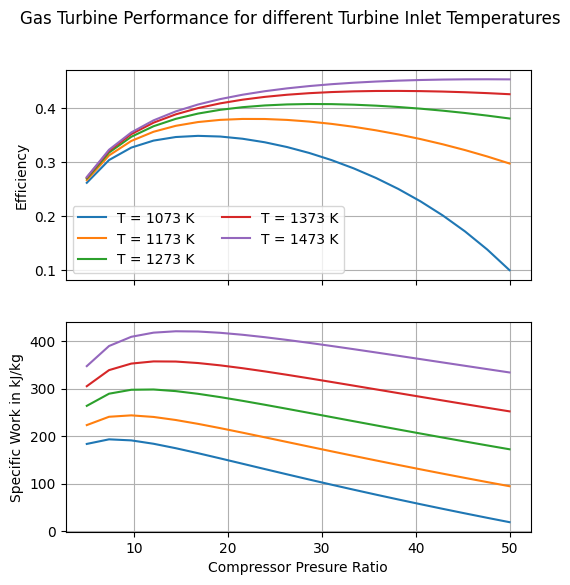

<Figure size 640x480 with 0 Axes>

In [7]:
from tespy.networks import Network
from tespy.connections import Connection
from tespy.components import(
    Source,
    Compressor,
    DiabaticCombustionChamber,
    Turbine,
    Sink    
)
import numpy as np
import matplotlib.pyplot as plt

#create network
gt = Network()

#create components w/o parameters
amb = Source('ambient')
tank = Source('fuel tank')
comp = Compressor('compressor')
cc = DiabaticCombustionChamber('combustion chamber')
turb = Turbine('turbine')
stack = Sink('stack')

#set up topology
ai = Connection(amb, 'out1', comp, 'in1', 'air inlet')
co = Connection(comp, 'out1', cc, 'in1', 'compressor outlet')
cf = Connection(tank, 'out1', cc, 'in2', 'combustion fuel')
ti = Connection(cc, 'out1', turb, 'in1', 'turbine inlet')
ex = Connection(turb, 'out1', stack, 'in1', 'exhaust')

gt.add_conns(ai, co, cf, ti, ex)

#stable parametrization
Pi = 10
TIT = 1273.15
p_amb = 1e5
T_amb = 293.15
air = {'N2': 0.79, 'O2': 0.21}
fuel = {'H2':1}
ai.set_attr(m=100, p=p_amb, T=T_amb, fluid=air)
cf.set_attr(p=p_amb*Pi, T=T_amb, fluid=fuel)
ex.set_attr(p=p_amb)
comp.set_attr(pr=Pi, eta_s=0.9)
cc.set_attr(eta=1, lamb=3, pr=0.95)
turb.set_attr(eta_s=0.9)

#solve stable configuration
gt.set_attr(iterinfo=False)
gt.solve(mode='design')

#prepare new parametrization
cc.set_attr(lamb=None)
ti.set_attr(T=TIT)

gt.solve(mode='design')

# prepare parameter matrix and result array
n_TIT = 5
n_Pi = 20
eta = np.empty([n_TIT, n_Pi])
wp = np.empty([n_TIT, n_Pi])

TIT_range = np.linspace(800+273.15, 1200+273.15, n_TIT)
Pi_range = np.linspace(5, 50, n_Pi)

# prepare plot
fig = plt.figure(figsize=[6,6])
ax_eta =fig.add_subplot(211)
ax_wp =fig.add_subplot(212)

# simulate and plot in a loop
i = 0
for TIT_n in TIT_range:
    j = 0
    ti.set_attr(T=TIT_n)
    for Pi_n in Pi_range:
        comp.set_attr(pr=Pi_n)
        cf.set_attr(p=p_amb*Pi_n)
        gt.solve(mode='design')
        eta[i, j]=(abs(turb.get_attr('P').val) - comp.get_attr('P').val) / cc.calc_ti()
        wp[i, j]=(abs(turb.get_attr('P').val) - comp.get_attr('P').val) / ai.get_attr('m').val / 1e3
        j +=1
    ax_eta.plot(Pi_range, eta[i])
    ax_wp.plot(Pi_range, wp[i])
    i +=1

#format plot and show
fig.suptitle('Gas Turbine Performance for different Turbine Inlet Temperatures')
ax_eta.set_ylabel('Efficiency')
ax_wp.set_xlabel('Compressor Presure Ratio')
ax_wp.set_ylabel('Specific Work in kJ/kg')
labels = [f'T = {TIT_n:.0f} K' for TIT_n in TIT_range]
ax_eta.legend(labels, loc='lower left', ncols=2)
ax_eta.grid(True)
ax_wp.grid(True)
ax_eta.sharex(ax_wp)
ax_eta.tick_params(labelbottom=False)
plt.show()

#save figure
plt.savefig('img/gt_performance.svg')


It is as well possible to export data, e.g. into csv-files. The script below puts the data into numpy arrays and arranges them in [pandas](https://pandas.pydata.org/) dataframes adding both headings for columns and rows. Finally the data is exported to csv.

In [6]:
from tespy.networks import Network
from tespy.connections import Connection
from tespy.components import(
    Source,
    Compressor,
    DiabaticCombustionChamber,
    Turbine,
    Sink    
)
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

#create network
gt = Network()

#create components w/o parameters
amb = Source('ambient')
tank = Source('fuel tank')
comp = Compressor('compressor')
cc = DiabaticCombustionChamber('combustion chamber')
turb = Turbine('turbine')
stack = Sink('stack')

#set up topology
ai = Connection(amb, 'out1', comp, 'in1', 'air inlet')
co = Connection(comp, 'out1', cc, 'in1', 'compressor outlet')
cf = Connection(tank, 'out1', cc, 'in2', 'combustion fuel')
ti = Connection(cc, 'out1', turb, 'in1', 'turbine inlet')
ex = Connection(turb, 'out1', stack, 'in1', 'exhaust')

gt.add_conns(ai, co, cf, ti, ex)

#stable parametrization
Pi = 10
TIT = 1273.15
p_amb = 1e5
T_amb = 293.15
air = {'N2': 0.79, 'O2': 0.21}
fuel = {'H2':1}
ai.set_attr(m=100, p=p_amb, T=T_amb, fluid=air)
cf.set_attr(p=p_amb*Pi, T=T_amb, fluid=fuel)
ex.set_attr(p=p_amb)
comp.set_attr(pr=Pi, eta_s=0.9)
cc.set_attr(eta=1, lamb=3, pr=0.95)
turb.set_attr(eta_s=0.9)

#solve stable configuration
gt.set_attr(iterinfo=False)
gt.solve(mode='design')

#prepare new parametrization
cc.set_attr(lamb=None)
ti.set_attr(T=TIT)

gt.solve(mode='design')

# prepare parameter matrix and result array
n_TIT = 6
n_Pi = 25
eta = np.empty([n_TIT, n_Pi])
wp = np.empty([n_TIT, n_Pi])

TIT_range = np.linspace(800+273.15, 1200+273.15, n_TIT)
Pi_range = np.linspace(5, 50, n_Pi)

# simulate and plot in a loop
i = 0
for TIT_n in TIT_range:
    j = 0
    ti.set_attr(T=TIT_n)
    for Pi_n in Pi_range:
        comp.set_attr(pr=Pi_n)
        cf.set_attr(p=p_amb*Pi_n)
        gt.solve(mode='design')
        eta[i, j]=(abs(turb.get_attr('P').val) - comp.get_attr('P').val) / cc.calc_ti()
        wp[i, j]=(abs(turb.get_attr('P').val) - comp.get_attr('P').val) / ai.get_attr('m').val / 1e3
        j +=1
    i +=1

#bring data into pandas dataframe and save
df_eta = pd.DataFrame(columns=Pi_range, index=TIT_range, data=eta)
df_wp = pd.DataFrame(columns=Pi_range, index=TIT_range, data=wp)
df_eta.to_csv('data/eta.csv')
df_wp.to_csv('data/wp.csv')
print('data saved to csv-files')

data saved to csv-files



## Next steps

It is definetly worth having a closer look to pandas as it allows for transferring data into other applications quite easily. There are even interfaces for importing and exporting MSExcel files for those who prefer working with them or need to pass data to MSOffice users.

Before moving to the next section it might even be a good idea to reflectadvantages and disadvantages of using TESPy in comparison to other tools or to just coding a taylor made straight forward script for a specific problem. Your choice will most likely depend on your personal preferences in engineering...

To prepare for the next session, you should make yourself familiar with Organic Rankine Cycles (ORC) as this will be the next subject. Additionally you should have a look at property charts and how they are used in thermal engineering of power or refrigeration cycles.
